In [11]:
import os
import pandas as pd


modelscoefficents = {}
rootdir = './RawData_last'
for dir in os.listdir(rootdir):
    if os.path.isdir(os.path.join(rootdir, dir)):
        modelscoefficents[dir] = {}
        modelscoefficents[dir]["Setname"] = []
        modelscoefficents[dir]["ModelType"] = []
        modelscoefficents[dir]["FeatName"] = []
        modelscoefficents[dir]["CoeffValue"] = []
        for file in os.listdir(os.path.join(rootdir, dir)):
            if file == 'modelscoefficients.csv':
                fp = open(os.path.join(rootdir, dir, file), 'r')
                lines = fp.readlines()
                for l in lines:
                    if l.find(' PLS ') == -1:
                        sl = l.split(',')
                        if len(sl) !=  3:
                            print('ERROR in', os.path.join(rootdir, dir, file))
                            exit(-1)
                        else:
                            for idx, e in enumerate(sl):
                                e = e.strip()
                                if idx == 0:
                                    se = e.split(' ')
                                    setname  = ''
                                    modeltype = ''

                                    if len(se) == 2:
                                        setname  = se[0]
                                        modeltype = se[1]
                                    else:
                                        setname  = se[0]
                                        modeltype = ' '.join(se[1:])
                                    modelscoefficents[dir]["Setname"].append(setname)
                                    modelscoefficents[dir]["ModelType"].append(modeltype)
                                elif idx == 1:
                                    modelscoefficents[dir]["FeatName"].append(e)
                                elif idx == 2:
                                    cv = float(e)
                                    modelscoefficents[dir]["CoeffValue"].append(cv)
                fp.close()


In [12]:
# check unconverged models so with Coefficients = 1
for model in modelscoefficents:
    for idx, val in enumerate(modelscoefficents[model]["CoeffValue"]):
        if val == 1.0:
            print(model, modelscoefficents[model]["Setname"][idx],\
                   modelscoefficents[model]["ModelType"][idx], \
                    modelscoefficents[model]["FeatName"][idx], \
                        modelscoefficents[model]["CoeffValue"][idx])

In [14]:
# transform Custom LR into MAPELR
for model in modelscoefficents:
    for idx, val in enumerate(modelscoefficents[model]["ModelType"]):
        if val == 'Custom LR':
            modelscoefficents[model]["ModelType"][idx] = 'MAPELR'

In [17]:
# use only MAPELR and LR data for the analysis
toincludepermodel = {}
for model in modelscoefficents:
    toinclude = []
    for idx, val in enumerate(modelscoefficents[model]["ModelType"]):
        if val == 'MAPELR' or val == 'LR':
            toinclude.append(idx)
    toincludepermodel[model] = toinclude

# create a new dictionary with only MAPELR and LR data
modelscoefficentsnew = {}
for model in modelscoefficents:
    modelscoefficentsnew[model] = {}
    modelscoefficentsnew[model]["Setname"] = []
    modelscoefficentsnew[model]["ModelType"] = []
    modelscoefficentsnew[model]["FeatName"] = []
    modelscoefficentsnew[model]["CoeffValue"] = []
    for idx in toincludepermodel[model]:
        modelscoefficentsnew[model]["Setname"].append(modelscoefficents[model]["Setname"][idx])
        modelscoefficentsnew[model]["ModelType"].append(modelscoefficents[model]["ModelType"][idx])
        modelscoefficentsnew[model]["FeatName"].append(modelscoefficents[model]["FeatName"][idx])
        modelscoefficentsnew[model]["CoeffValue"].append(modelscoefficents[model]["CoeffValue"][idx])

In [47]:
listtodump = ["PBE_MINIX", "PBE_SVP", "PBE_TZVP", "PBE_QZVP", \
              "PBE0_MINIX", "PBE0_SVP", "PBE0_TZVP", "PBE0_QZVP",]
featuresnames = ["FSPE", "EC", "EX", "DC", "PE", "KE", "OEE", "TEE", "NR"]
modeltypes = ["MAPELR"]
ssetnams = ["BARRIER_HEIGHTS", "INTRAMOLECULAR_INTERACTIONS", \
            "SMALL_MOLECULES", "INTERMOLECULAR_INTERACTIONS", \
            "LARGE_SYSTEMS", "Full"]

for mt in modeltypes:
    for model in listtodump:
        print(mt, model)
        for ssetnam in ssetnams:
            print("%10s , "%(ssetnam), end='')
        print()
        for commonfeatname  in featuresnames:
            
            print("%5s , "%(commonfeatname), end='')
            for ssetnam in ssetnams:
                for inx, feat in enumerate(modelscoefficentsnew[model]["FeatName"]):
                    if feat.find(commonfeatname) != -1 and \
                        modelscoefficentsnew[model]["ModelType"][inx] == mt and \
                            modelscoefficentsnew[model]["Setname"][inx] == ssetnam:
                        print(" %10.8f "%(modelscoefficentsnew[model]["CoeffValue"][inx]) , end='')   
            print()
    print()

MAPELR PBE_MINIX
BARRIER_HEIGHTS , INTRAMOLECULAR_INTERACTIONS , SMALL_MOLECULES , INTERMOLECULAR_INTERACTIONS , LARGE_SYSTEMS ,       Full , 
 FSPE ,  2.28660146  0.18012207  -1.08707627  -0.15358815  0.32064913  -0.30275257 
   EC ,  -2.19354850  -1.58097028  -0.46816176  -0.65468896  -1.14705068  -0.48581783 
   EX ,  0.66069951  0.64976761  0.24851071  0.34430035  0.23838384  0.13151197 
   DC ,  6.53725825  2.04054190  -0.33917371  1.35625456  2.29160891  1.77120478 
   PE ,  2.28660146  -1.14305569  0.18012207  0.05250692  -1.08707627  0.60226290  -0.15358815  0.23762389  0.32064913  0.00755586  -0.30275257  -0.06069155 
   KE ,  -1.10686193  0.08790400  0.64190526  0.25306567  0.02007670  -0.04587571 
  OEE ,  -0.41658963  0.37989989  0.74949932  0.49840678  0.33868676  0.61875645 
  TEE ,  -0.40782468  0.37949686  0.75259819  0.49951856  0.33319413  0.62055081 
   NR ,  -0.42514794  0.38031452  0.74613166  0.49729597  0.34416589  0.61696939 
MAPELR PBE_SVP
BARRIER_HEIGHTS , INT

In [3]:
# extract an equation given a startpoint, setname and modeltype
startpoint = 'PBE_SVP'
setname = 'BARRIER_HEIGHTS'
modeltype = 'Custom LR split'

for sp in modelscoefficents:
    if sp == startpoint:
        for idx, sn in enumerate(modelscoefficents[sp]["Setname"]):
            mt = modelscoefficents[sp]["ModelType"][idx]
            fn = modelscoefficents[sp]["FeatName"][idx]
            cv = modelscoefficents[sp]["CoeffValue"][idx]
            if sn == setname and mt == modeltype:
                if fn == 'Intercept':
                    print(f'{cv:.8f}', end=' ')
                else:
                    if cv > 0:
                        print(f'+ {cv:.8f} * {fn}', end=' ')
                    else:
                        print(f'- {-cv:.8f} * {fn}', end=' ')
        print('')

0.28520613 - 1.35903488 * PBE_SVP_EC + 0.36920577 * PBE_SVP_EX + 0.89336772 * PBE_SVP_FSPE + 3.34907069 * PBE_SVP_DC - 0.22832199 * PBE_SVP_PE - 0.22771519 * PBE_SVP_KE + 0.18155940 * PBE_SVP_OEE + 0.18529541 * PBE_SVP_TEE + 0.17781199 * PBE_SVP_NR 


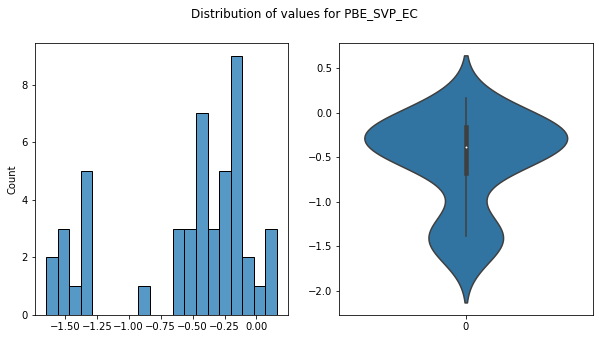

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_featurename_distribution (featname, plot=True):
    allvalues = []
    for sp in modelscoefficents:
        for idx, fn in enumerate(modelscoefficents[sp]["FeatName"]):
            if fn == featname:
                sn = modelscoefficents[sp]["Setname"][idx]
                mt = modelscoefficents[sp]["ModelType"][idx]
                cv = modelscoefficents[sp]["CoeffValue"][idx]
                allvalues.append(cv)
                #print(f'{sp} {sn} {mt} {cv:.8f}')

    # plot the distribution of the values


    # Create a boxplot
    #sns.set(style="whitegrid")
    #ax = sns.boxplot(allvalues)
    #plt.show()

    if not plot:
        return allvalues
    
    # create an histogram and a violin plot in the same figure
    plt.figure(figsize=(10, 5))
    # add a title to the plot
    plt.suptitle(f'Distribution of values for {featname}')
    plt.subplot(1, 2, 1)
    # create a histogram
    sns.histplot(allvalues, bins=20)
    plt.subplot(1, 2, 2)
    # create a violin plot
    sns.violinplot(data=allvalues)
    plt.show()

    return allvalues

# extract all values for a given featurename 
featname = 'PBE_SVP_EC'
allval = plot_featurename_distribution(featname)

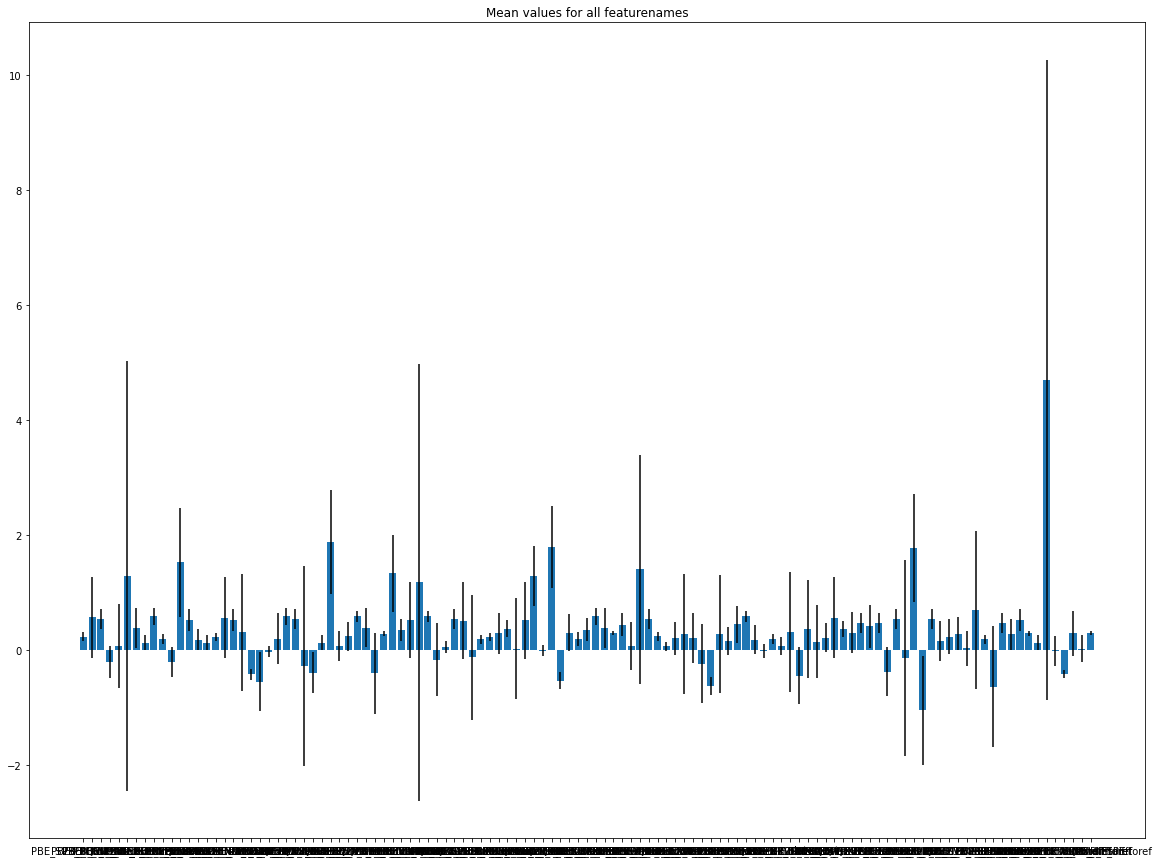

In [5]:
# extract all possible feature names
featnames = set()
avergesforfeatures = {}
for sp in modelscoefficents:
    for idx, fn in enumerate(modelscoefficents[sp]["FeatName"]):
        if fn not in featnames:
            featnames.add(fn)

for fn in featnames:
    allval = plot_featurename_distribution(fn, plot=False)
    avergesforfeatures[fn] = (np.mean(allval), 
                                min(allval), 
                                max(allval),  
                                np.std(allval),
                                len(allval))


#for fn in featnames:
#    print("%25s %11.8f %11.8f %11.8f %11.8f %3d" % (fn, \
#                avergesforfeatures[fn][0], \
#                avergesforfeatures[fn][1], \
#                avergesforfeatures[fn][2], \
#                avergesforfeatures[fn][3], \
#                avergesforfeatures[fn][4]))
# collect all meanvalues 
meanvalues = []
stdvalues = []
featurenames = []
for fn in featnames:
    meanvalues.append(avergesforfeatures[fn][0])
    stdvalues.append(avergesforfeatures[fn][3])
    featurenames.append(fn)

# plot the mean values 
plt.figure(figsize=(20, 15))
# add a title to the plot
plt.title(f'Mean values for all featurenames')
plt.bar(featurenames, meanvalues, yerr=stdvalues)
plt.show()

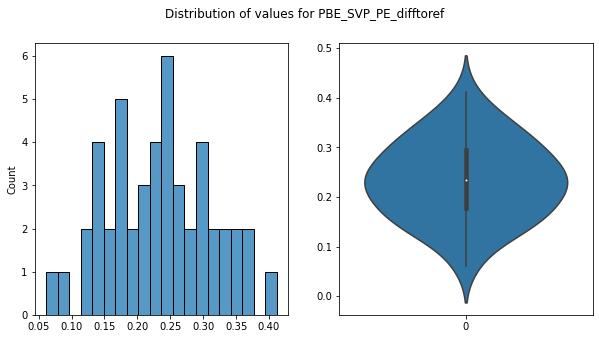

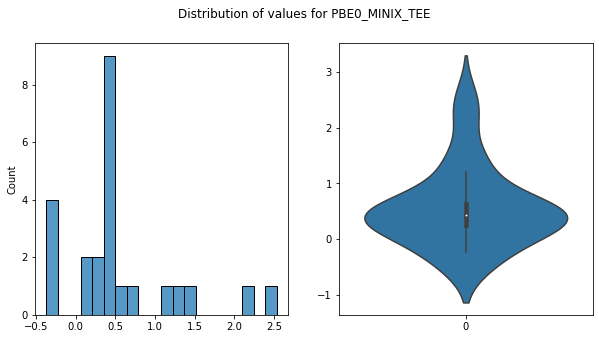

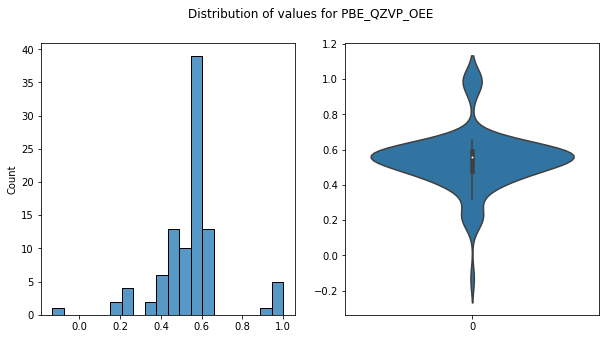

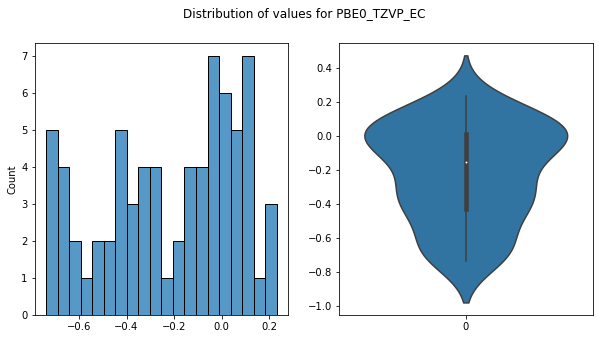

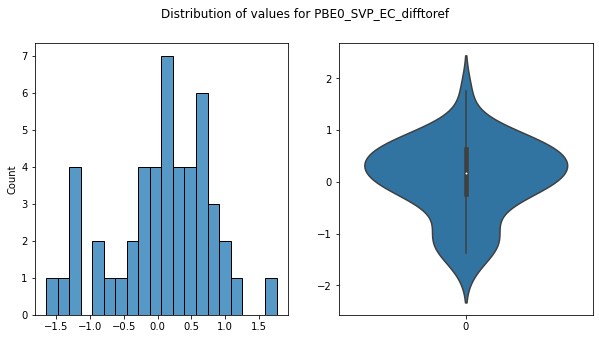

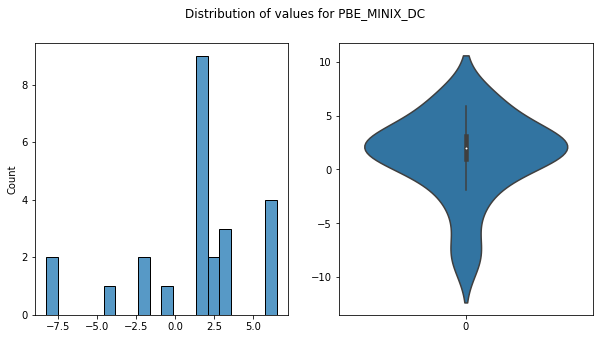

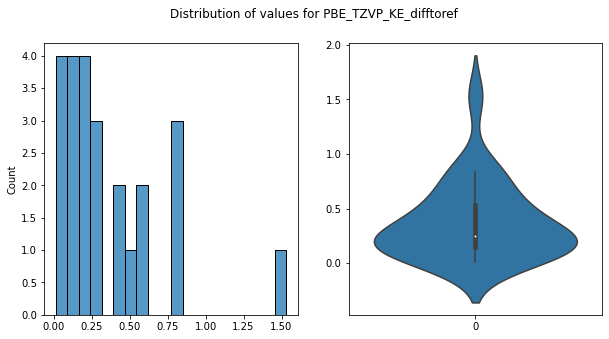

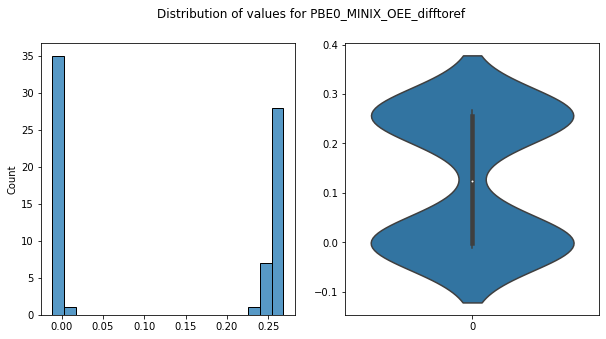

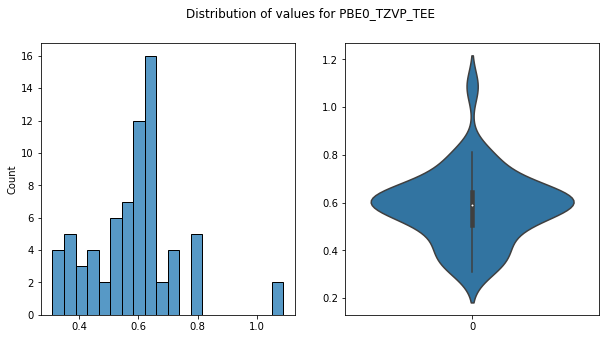

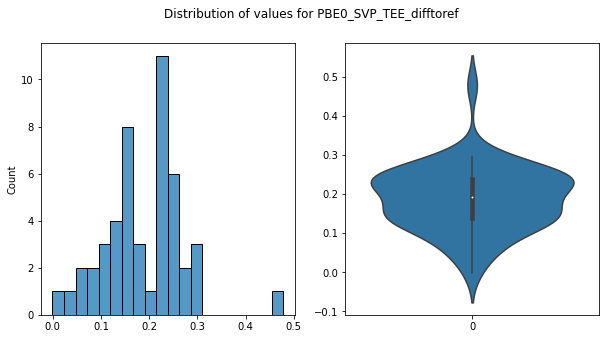

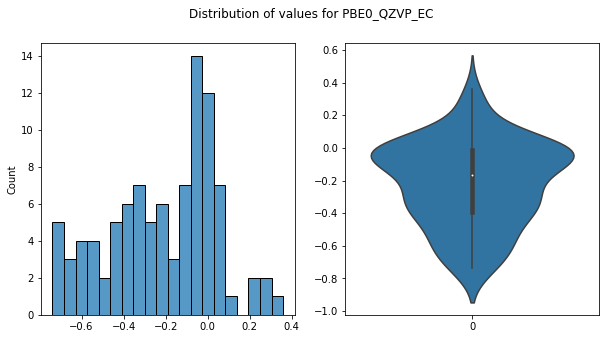

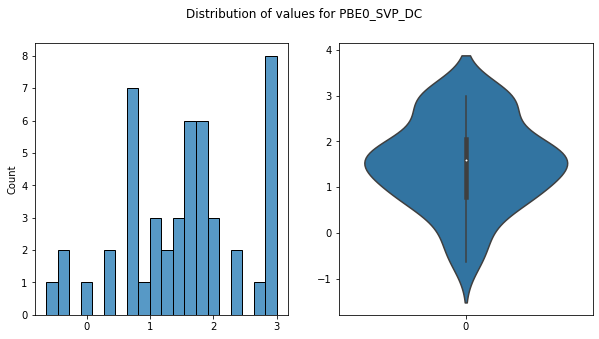

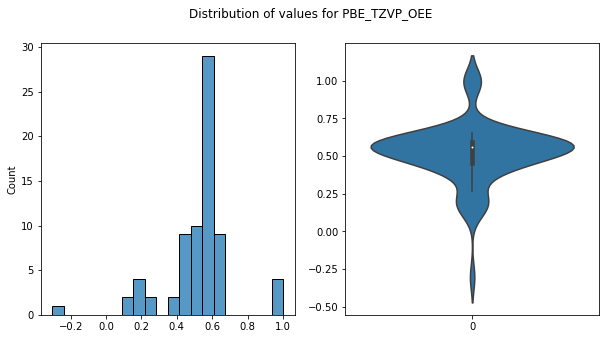

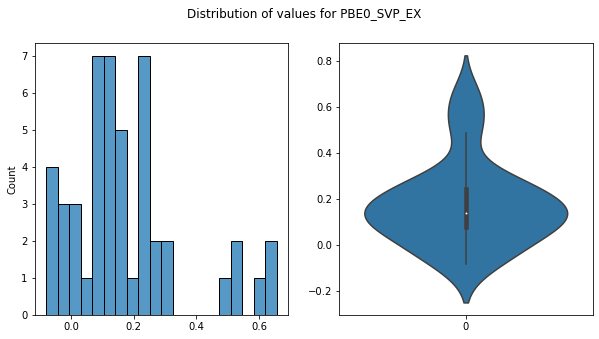

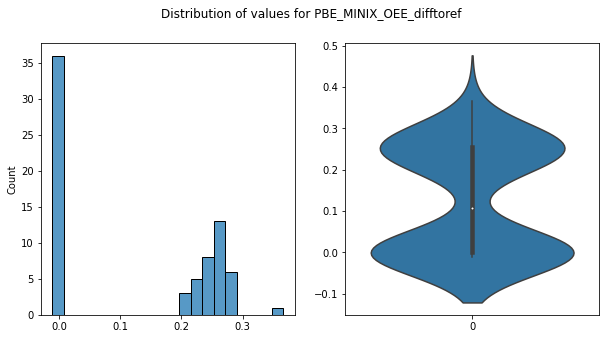

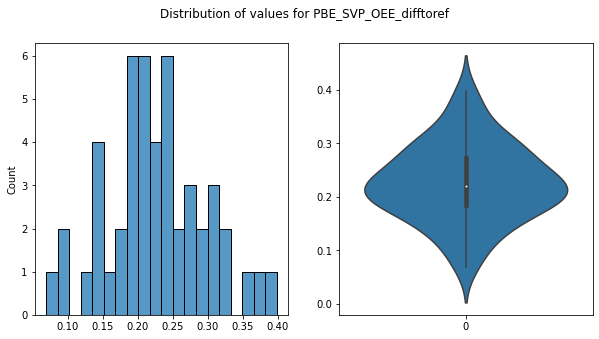

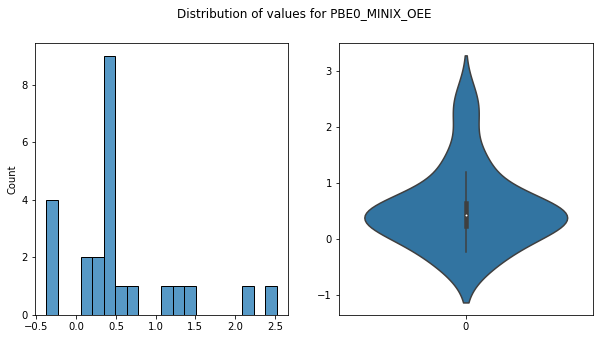

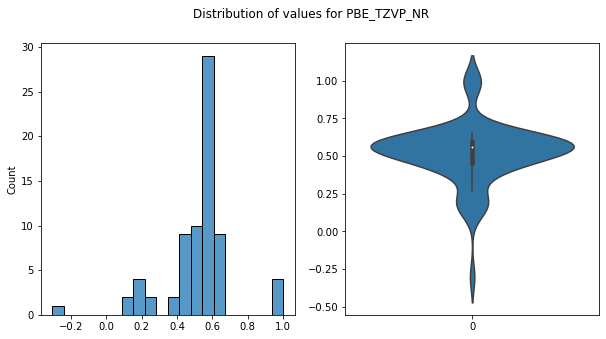

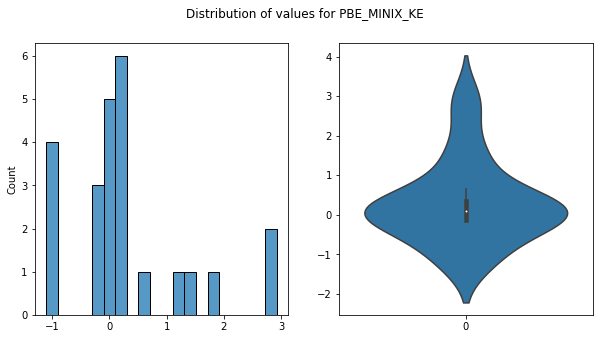

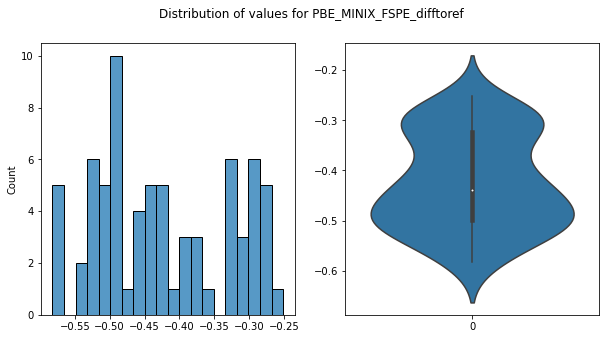

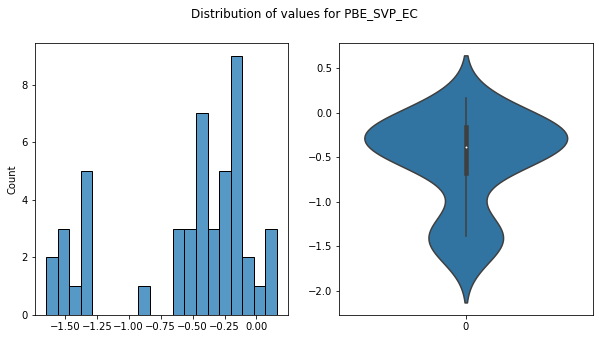

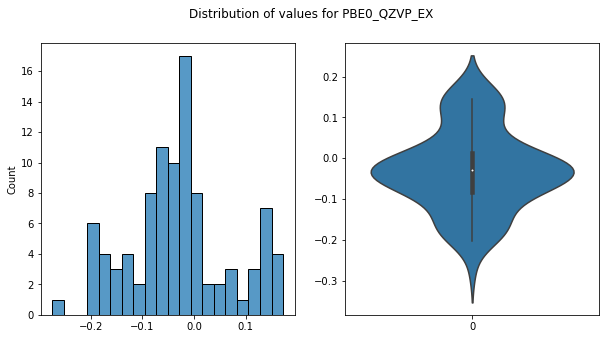

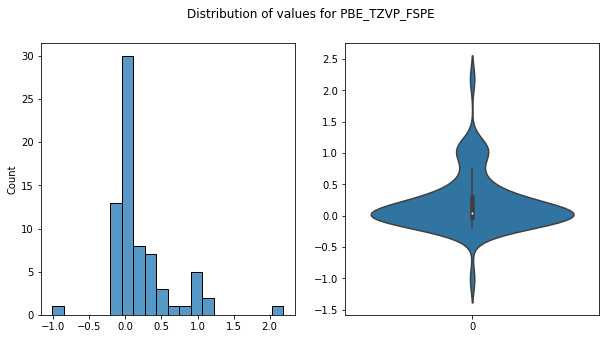

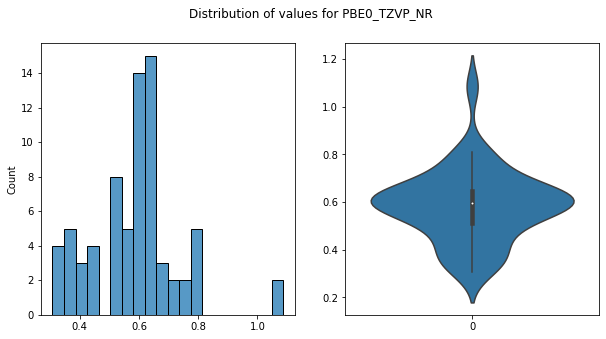

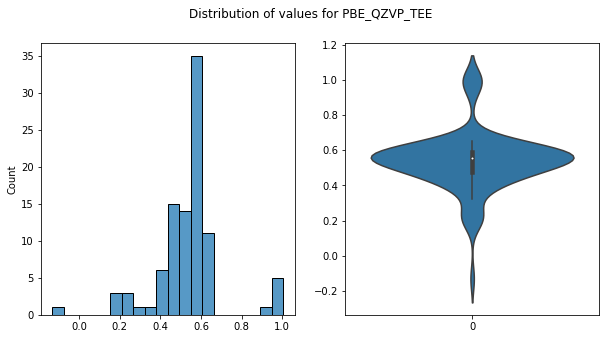

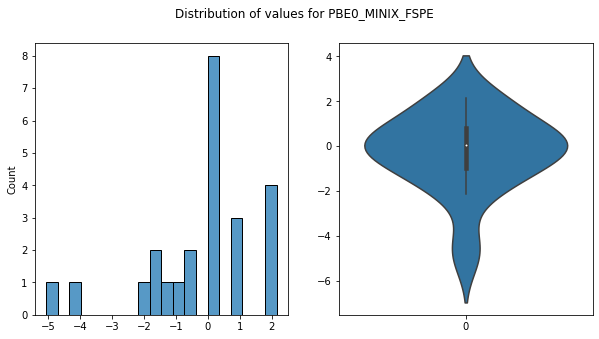

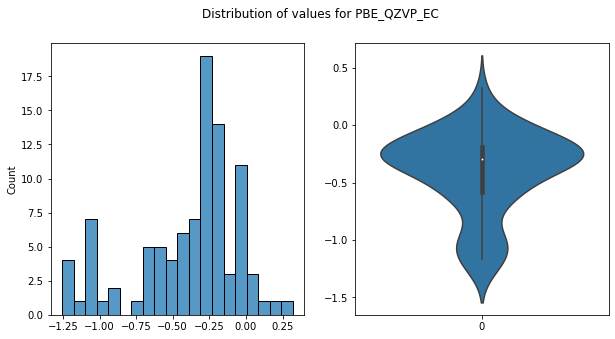

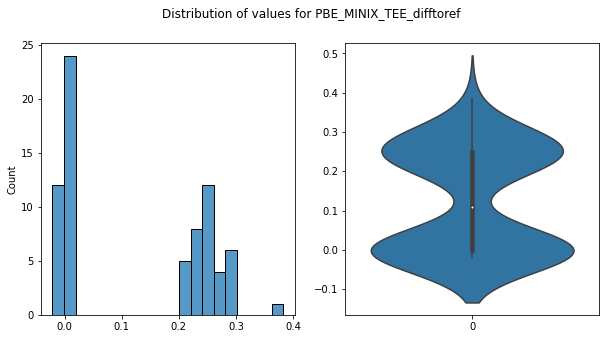

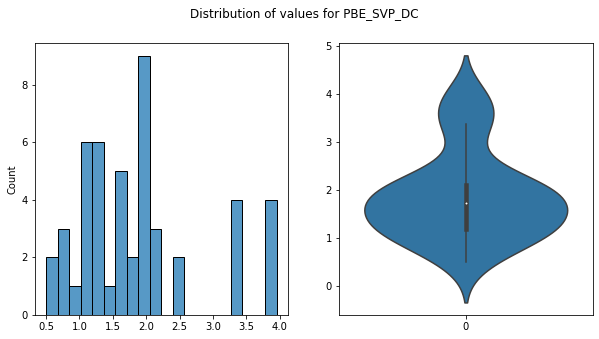

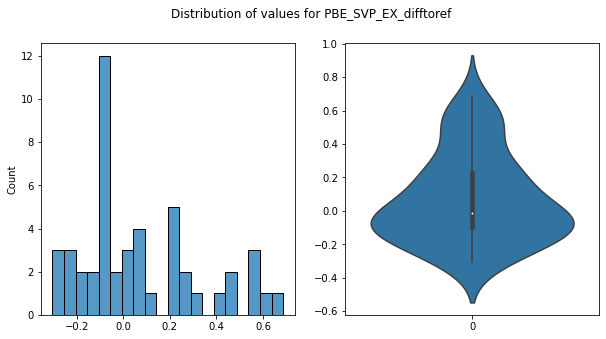

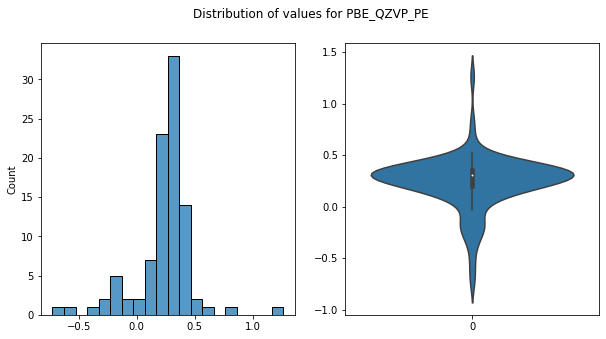

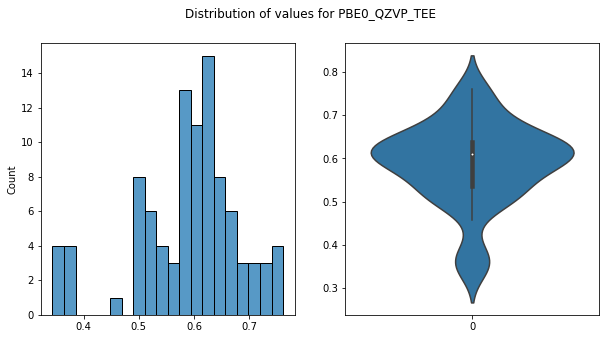

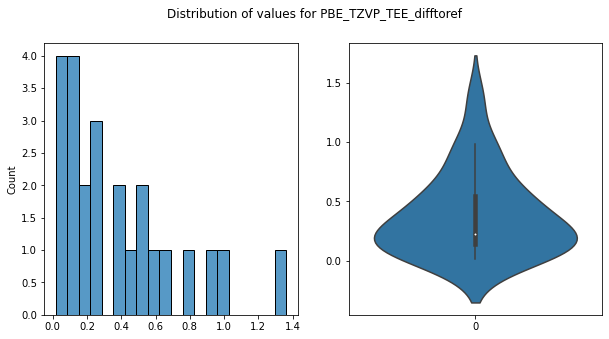

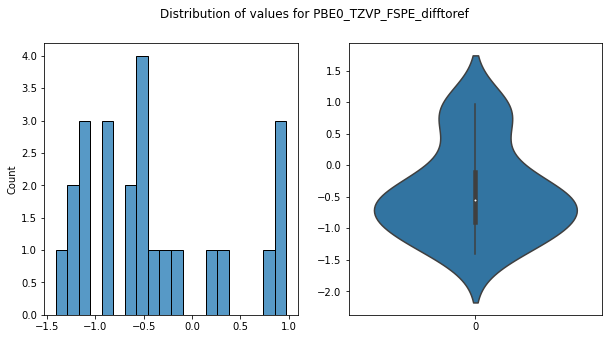

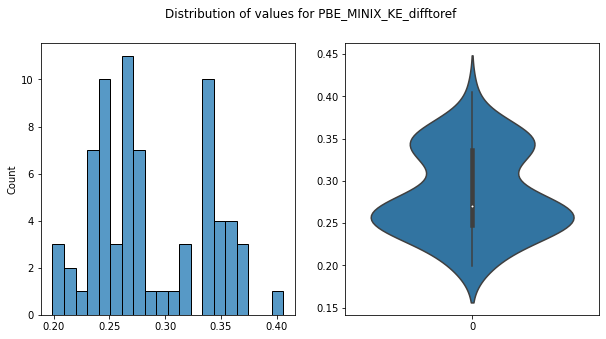

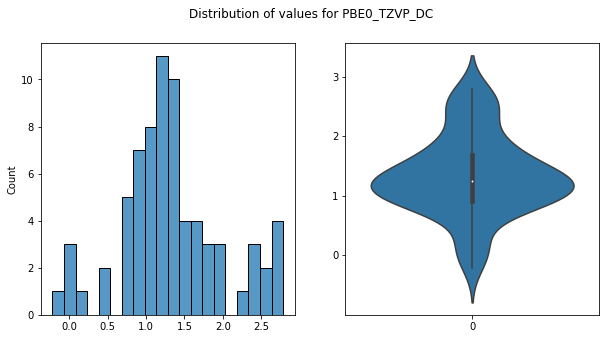

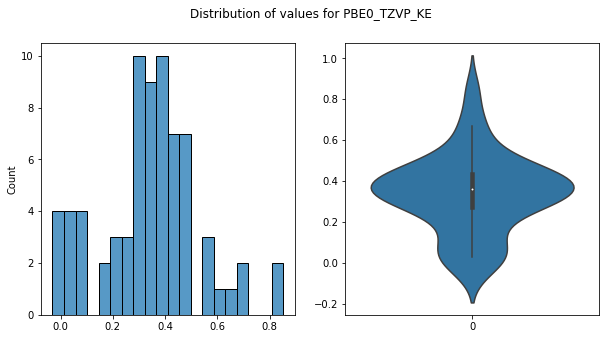

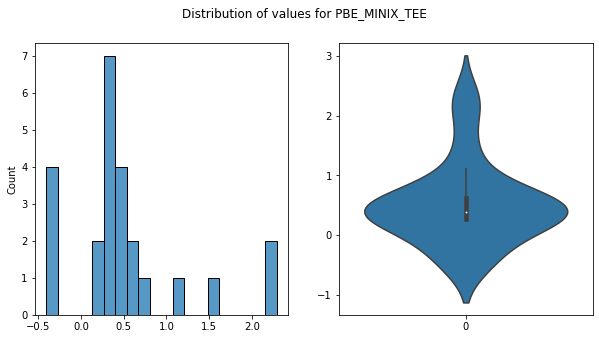

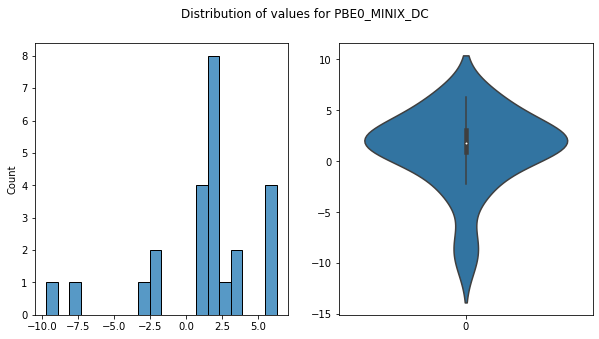

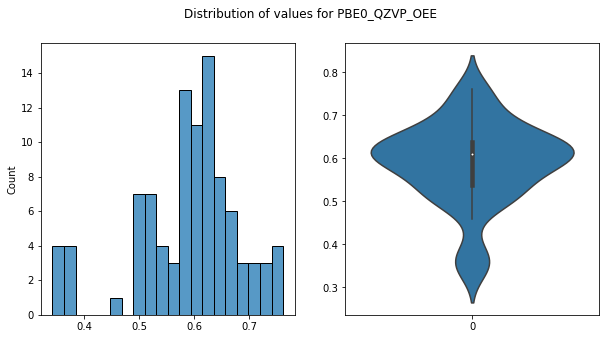

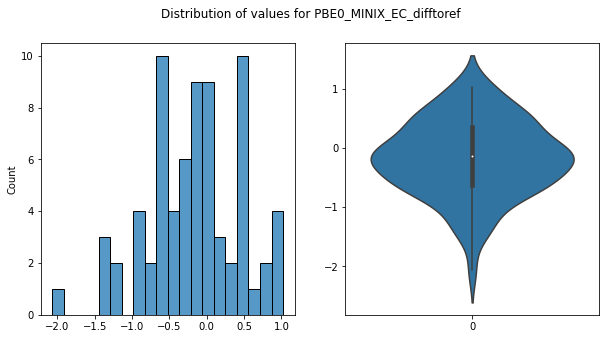

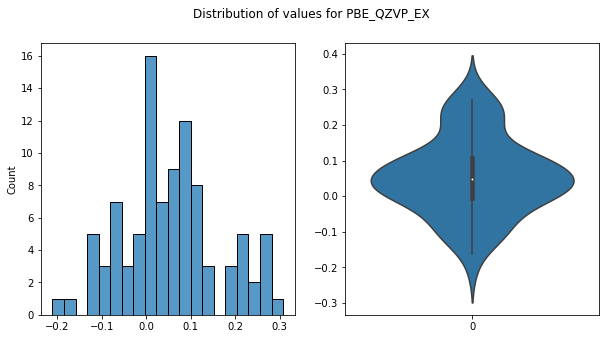

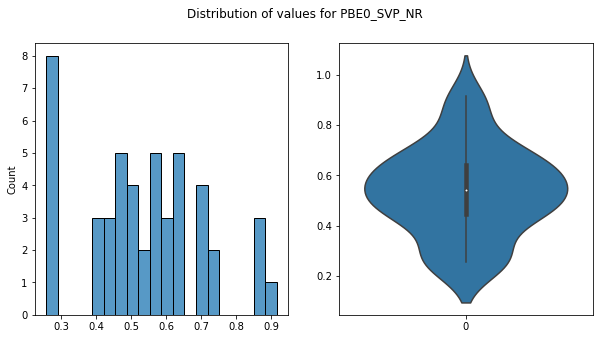

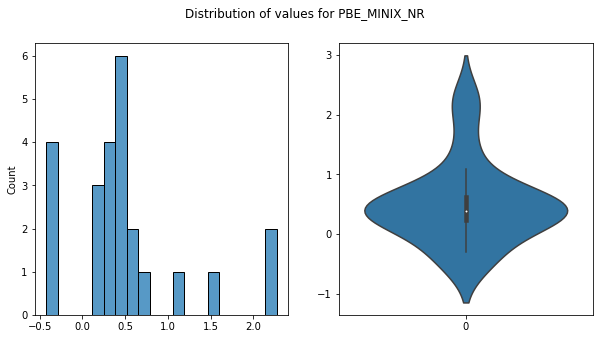

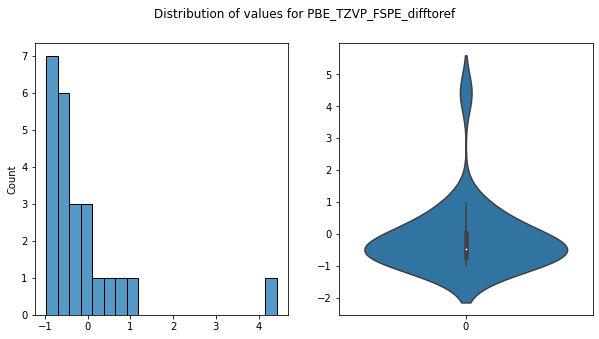

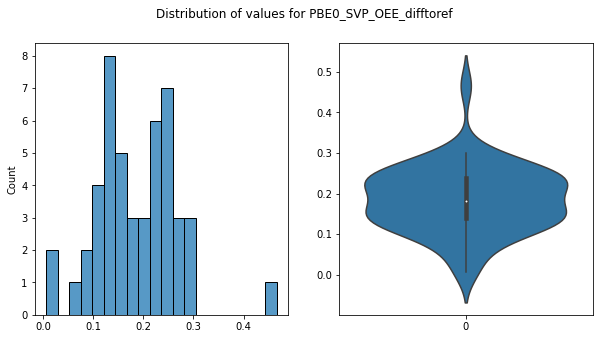

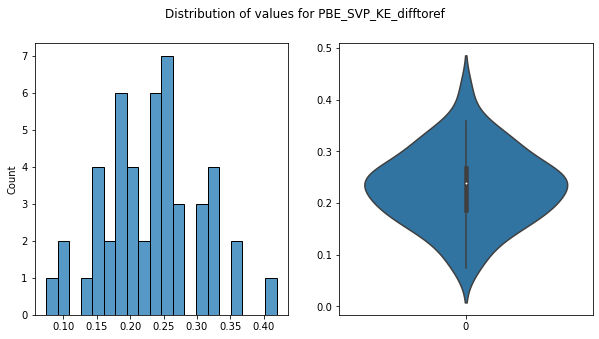

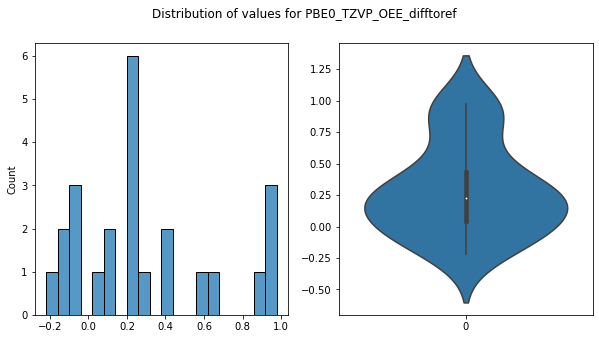

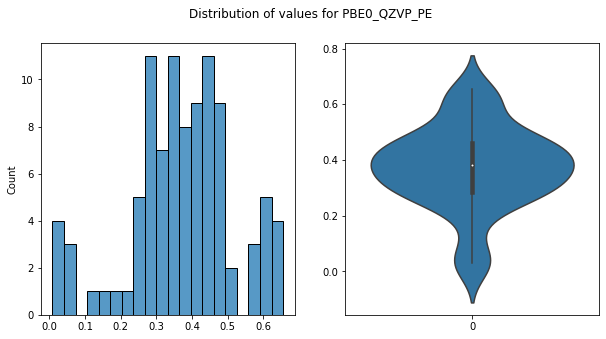

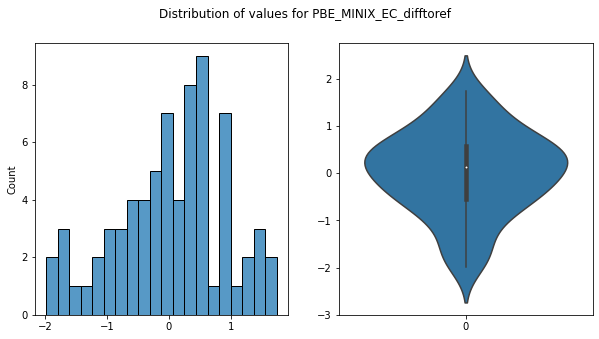

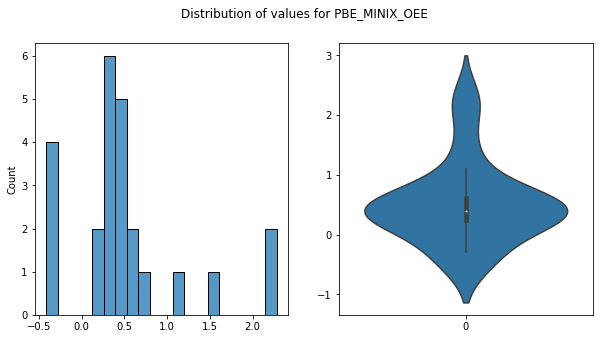

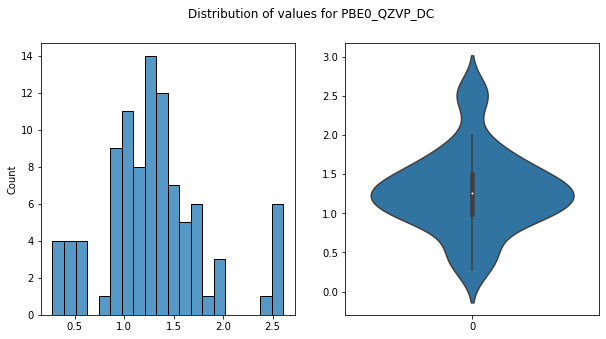

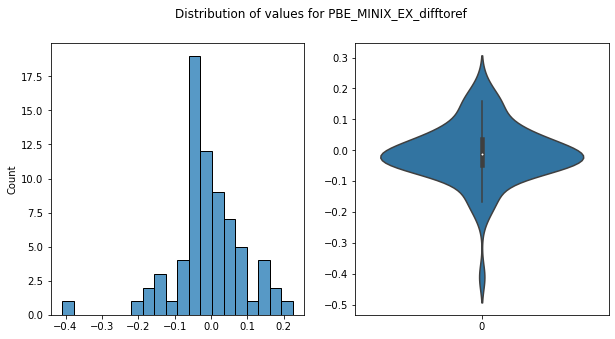

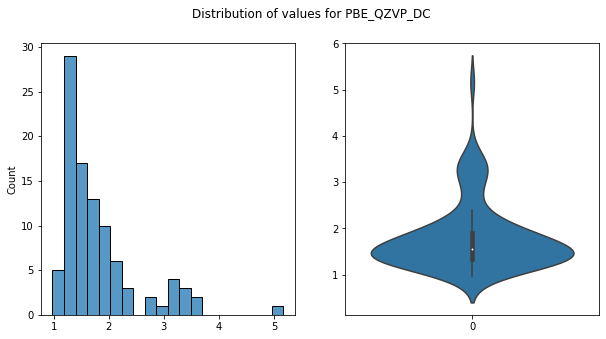

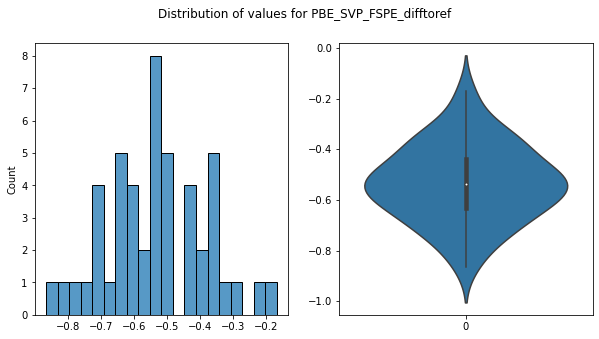

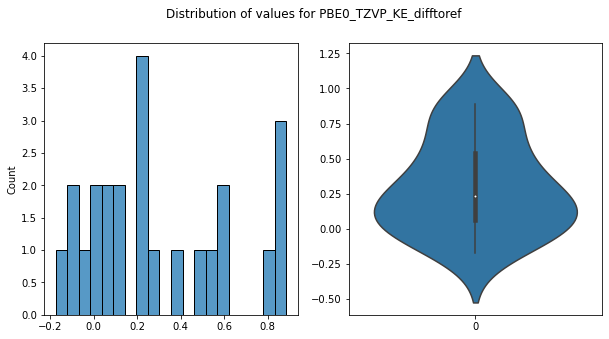

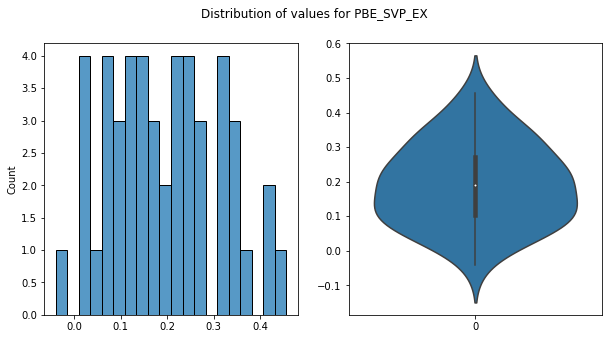

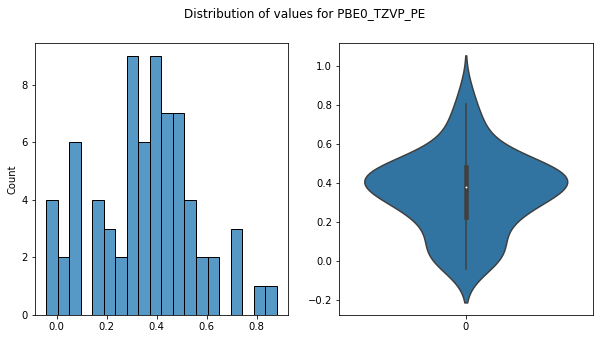

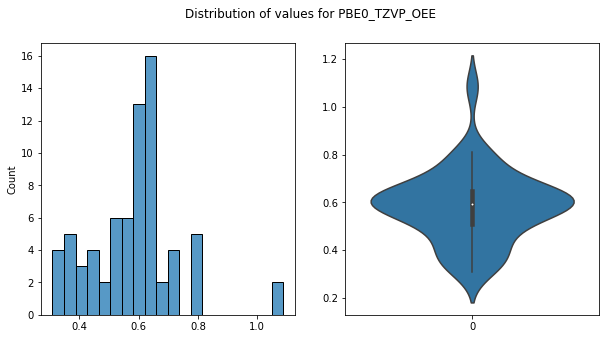

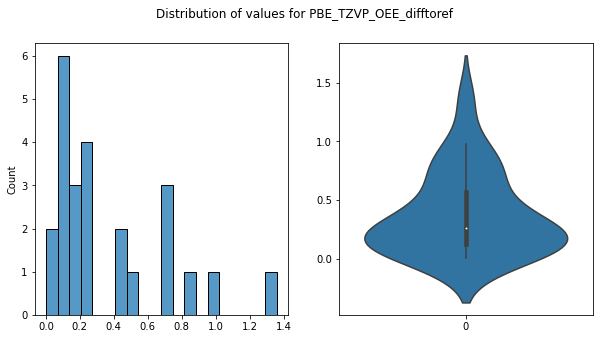

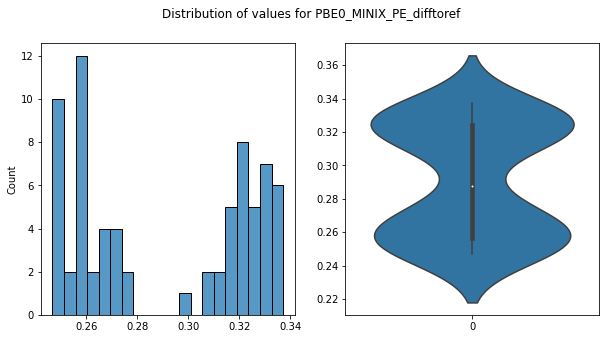

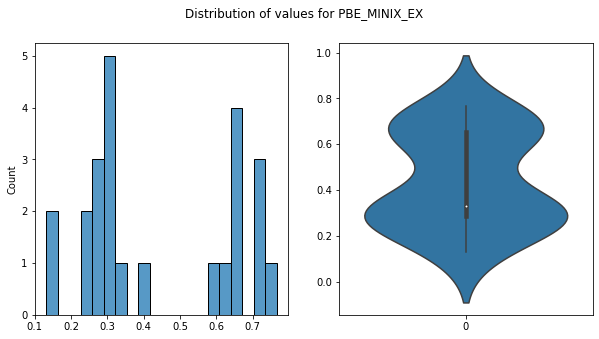

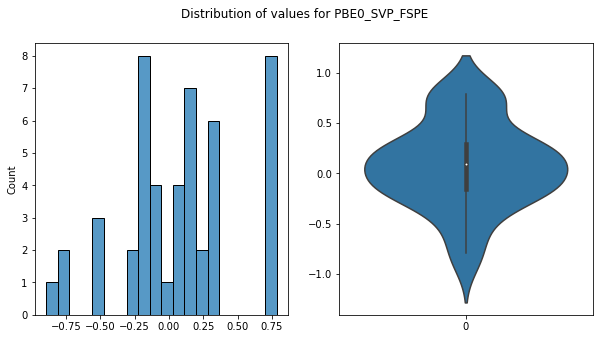

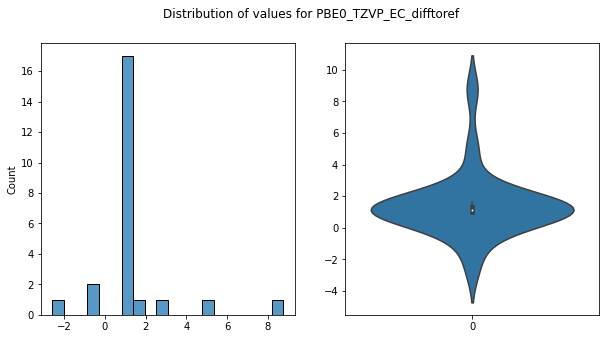

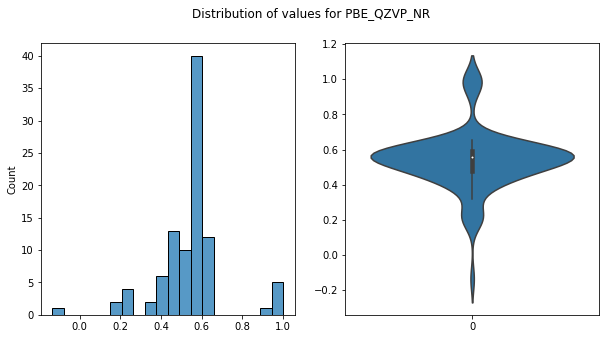

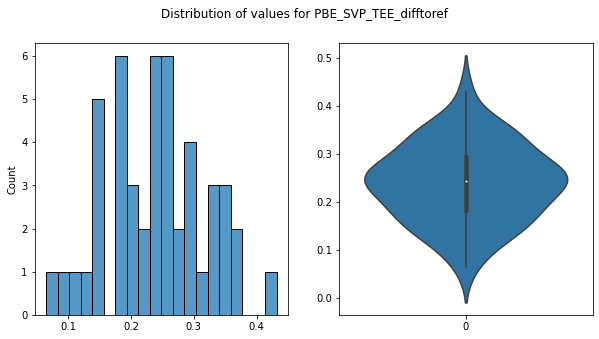

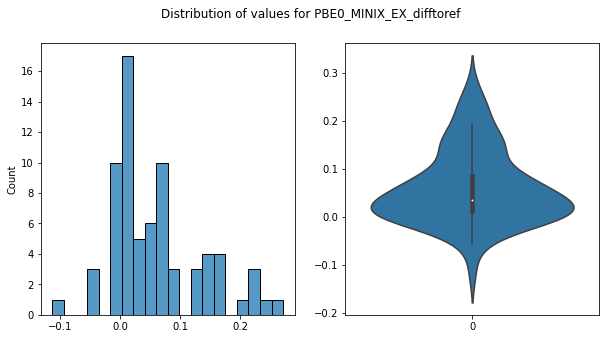

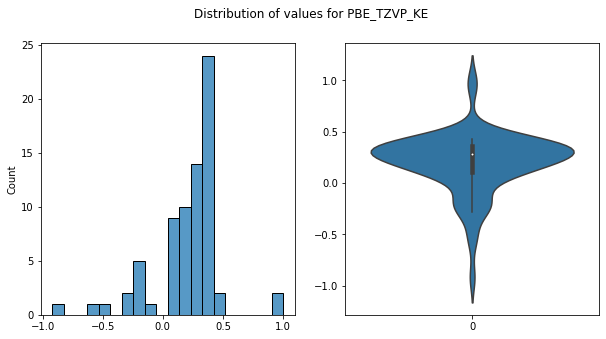

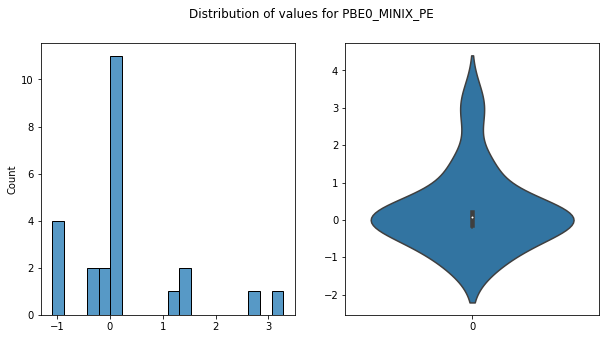

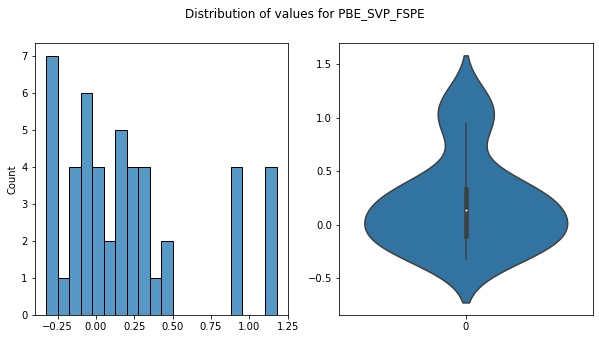

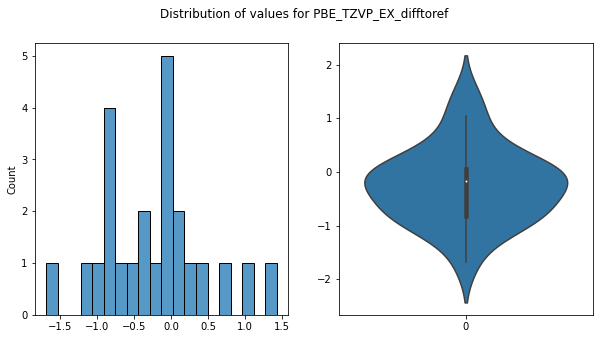

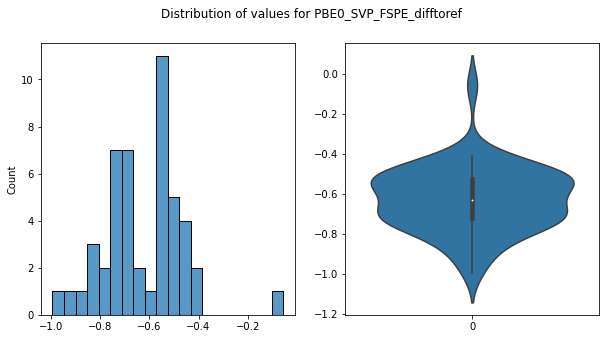

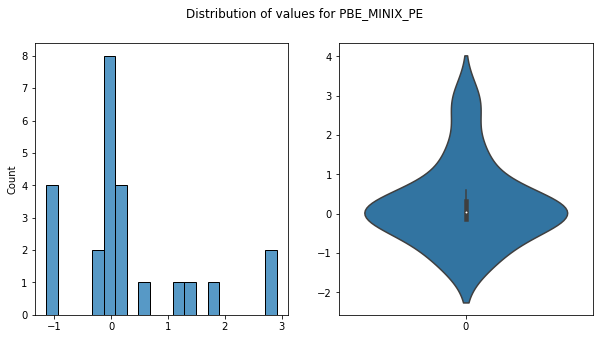

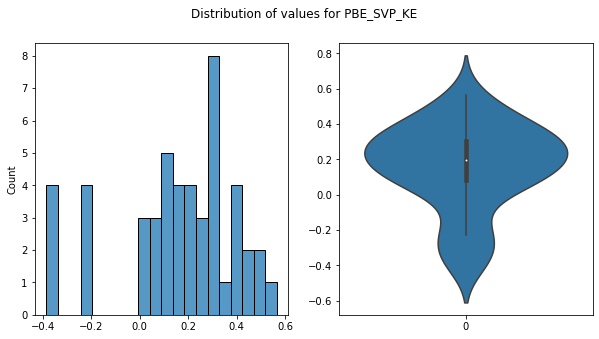

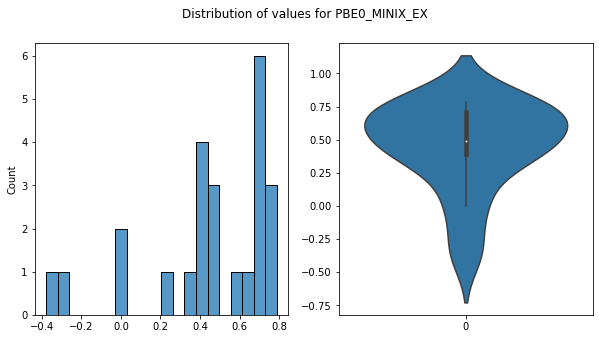

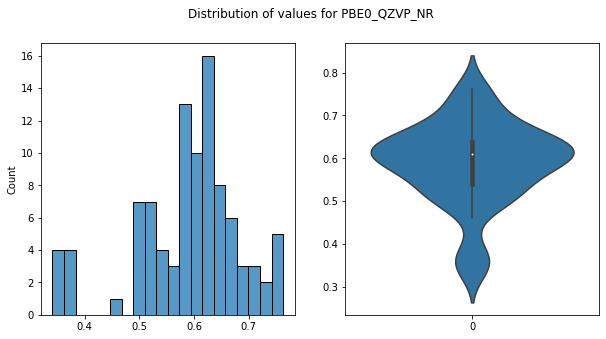

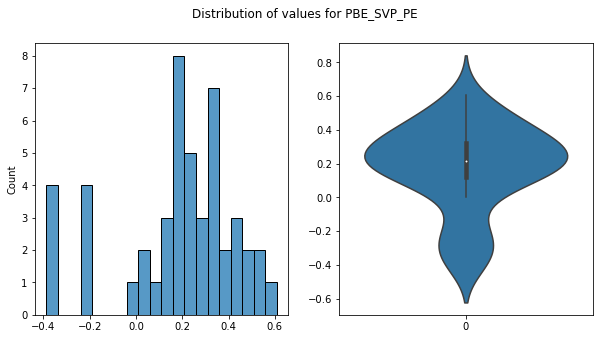

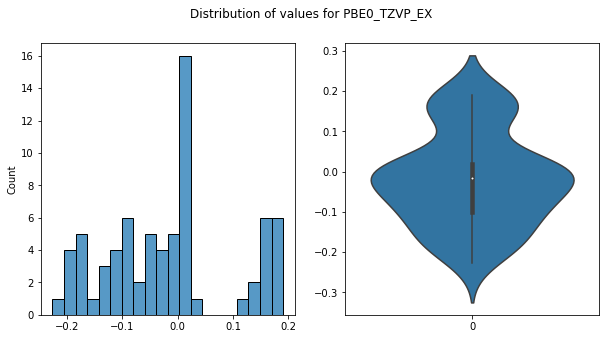

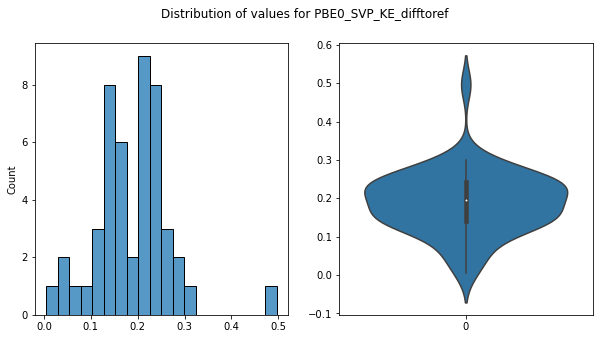

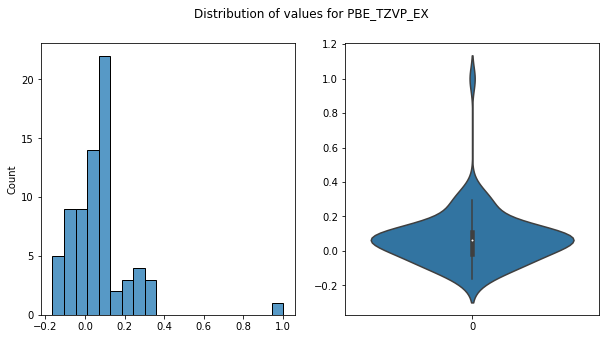

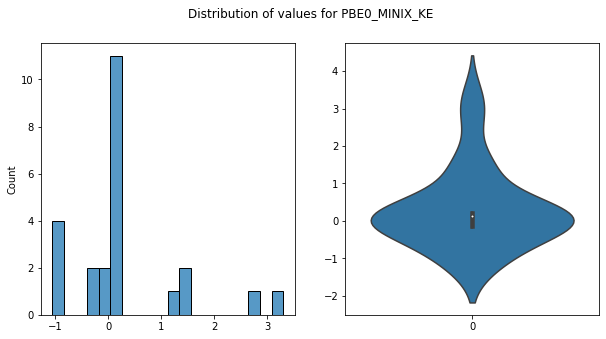

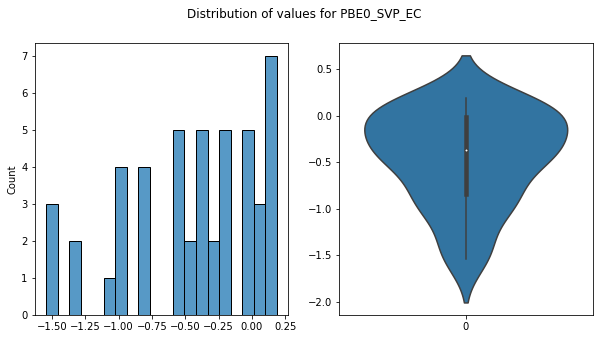

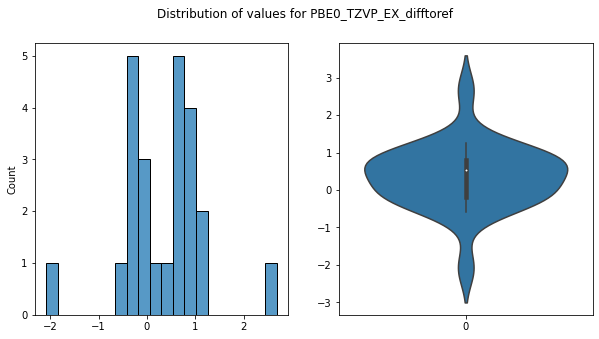

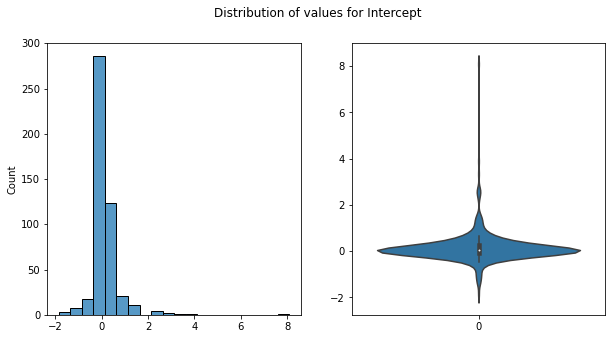

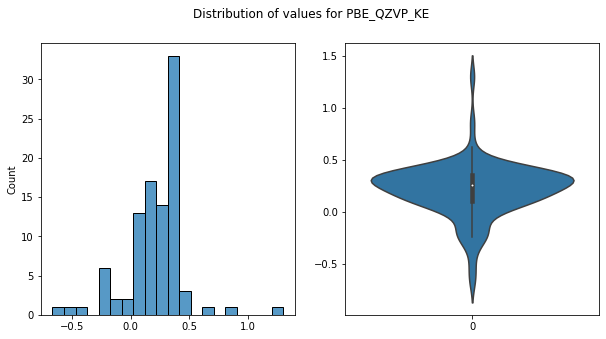

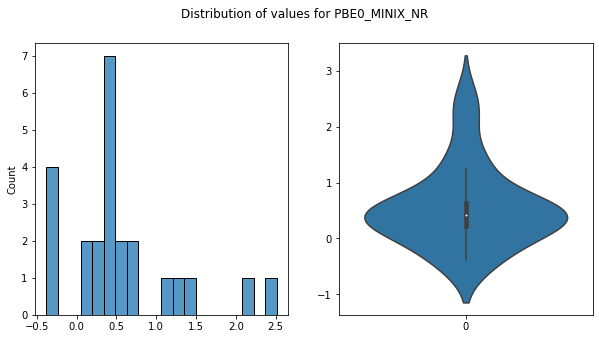

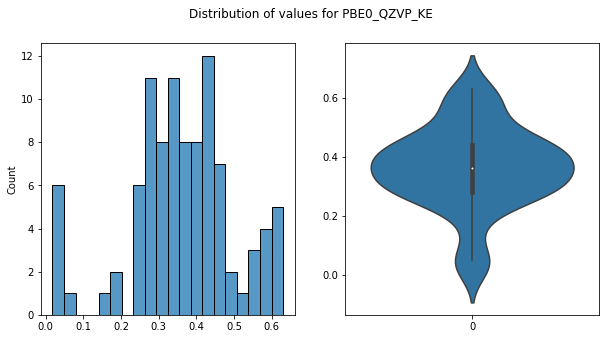

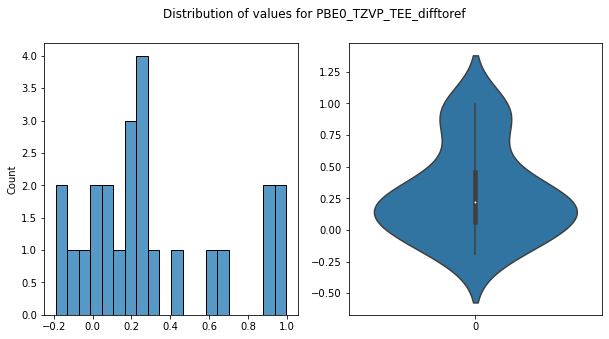

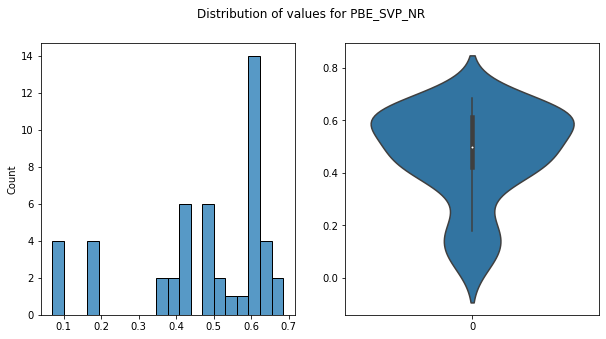

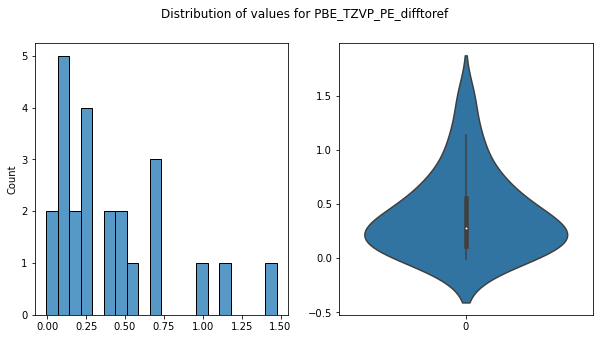

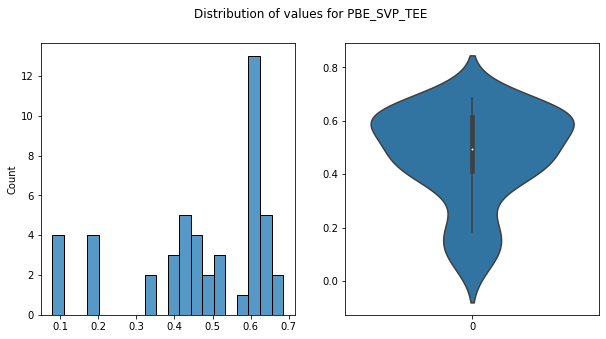

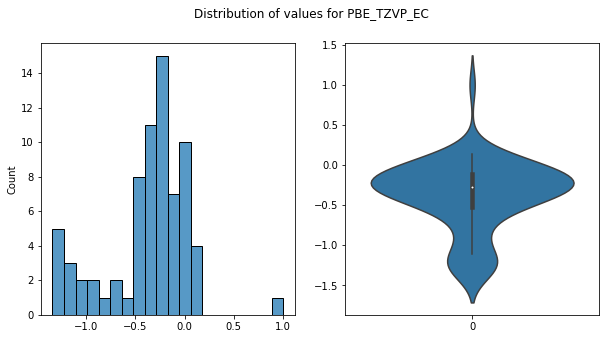

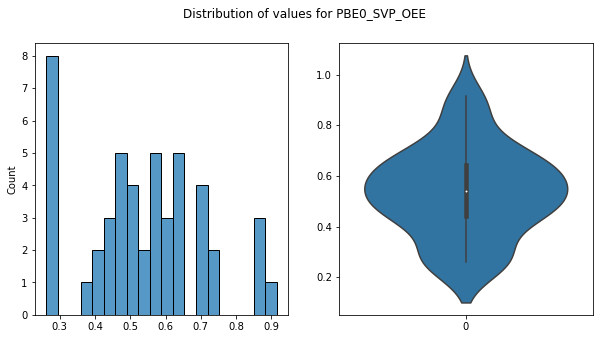

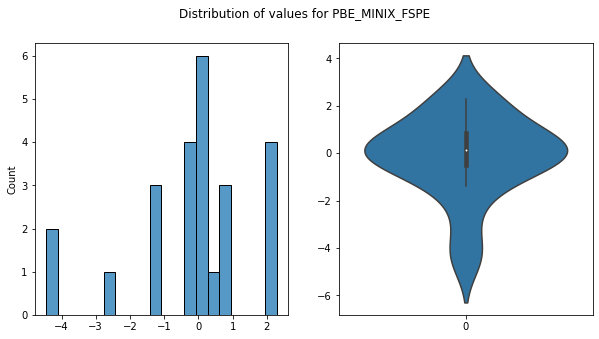

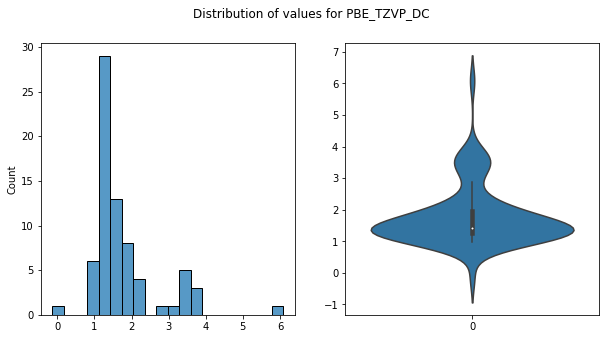

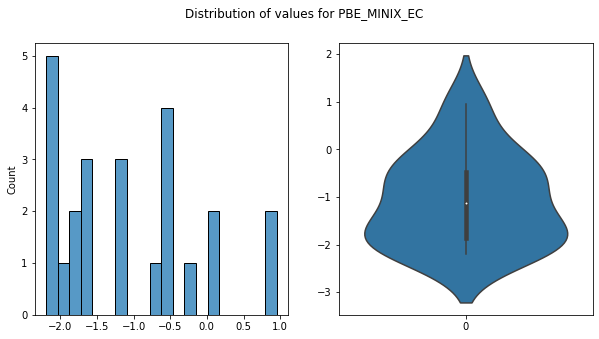

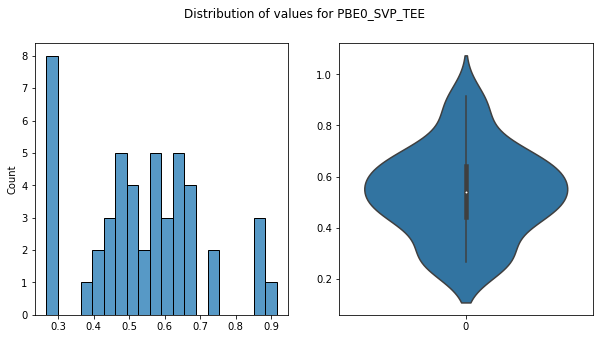

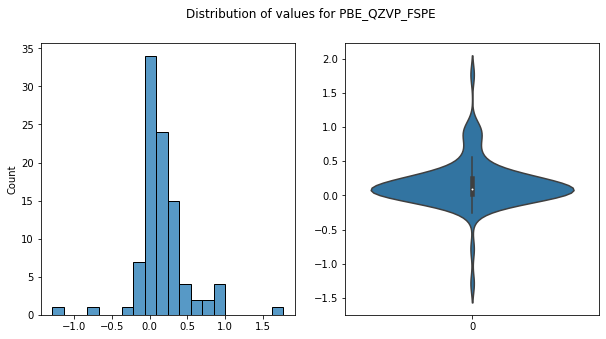

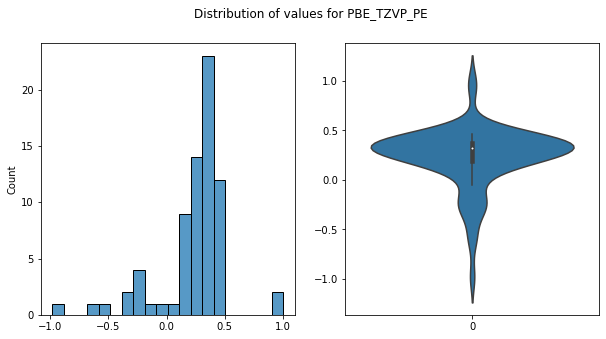

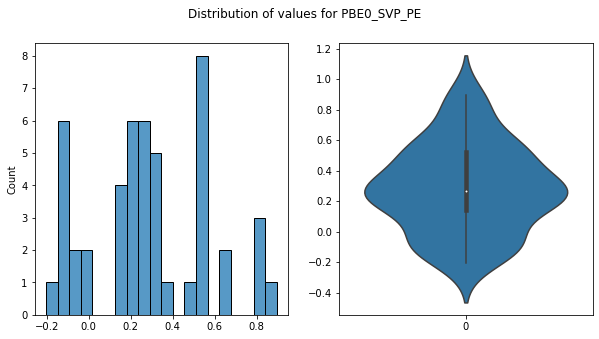

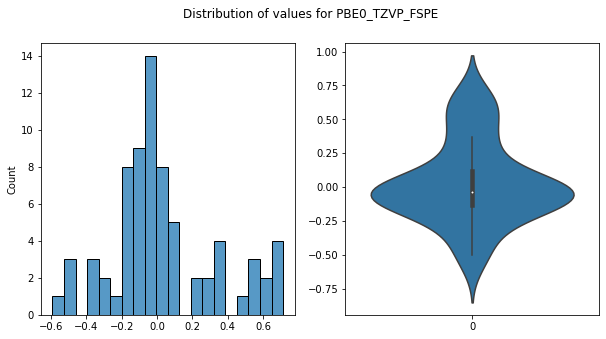

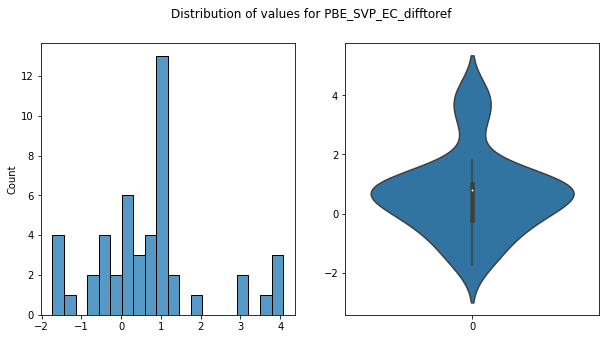

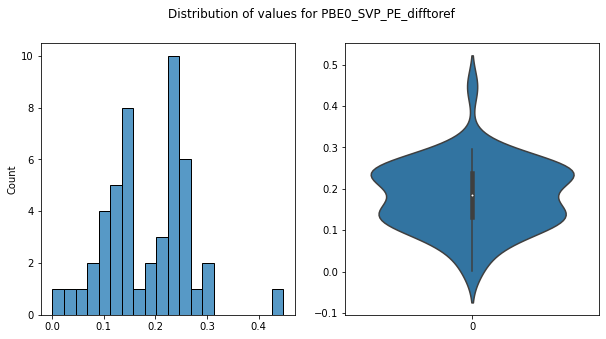

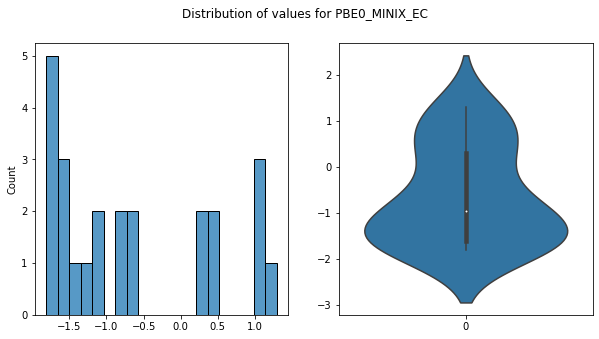

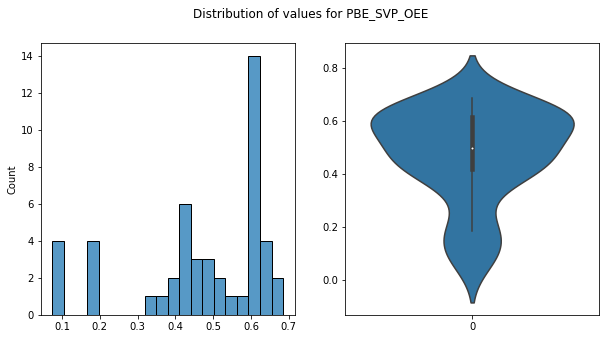

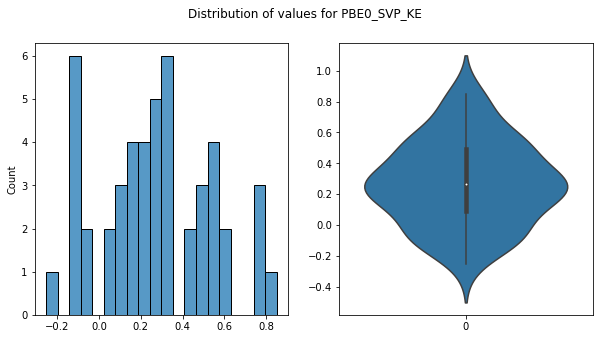

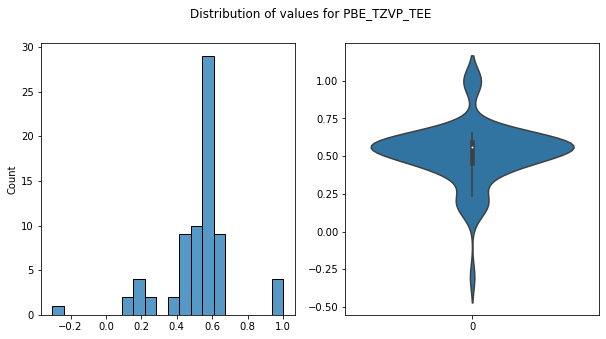

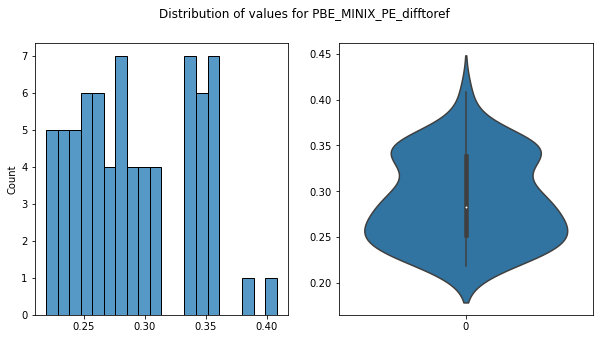

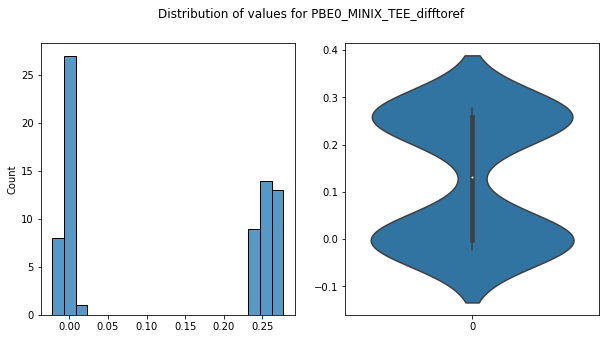

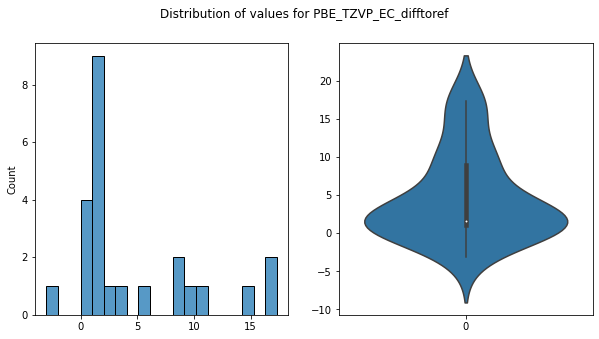

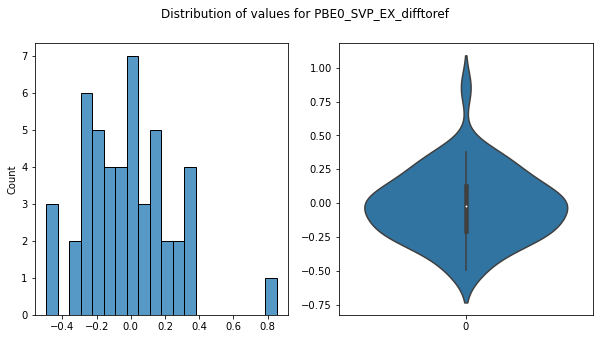

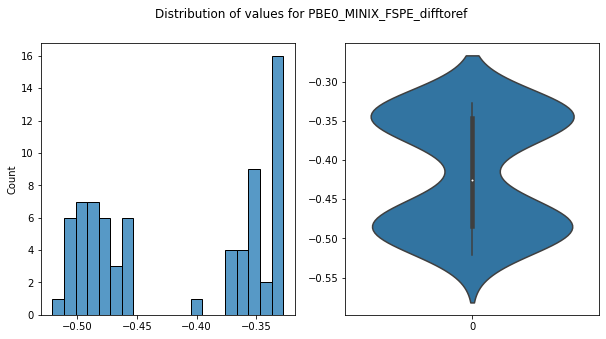

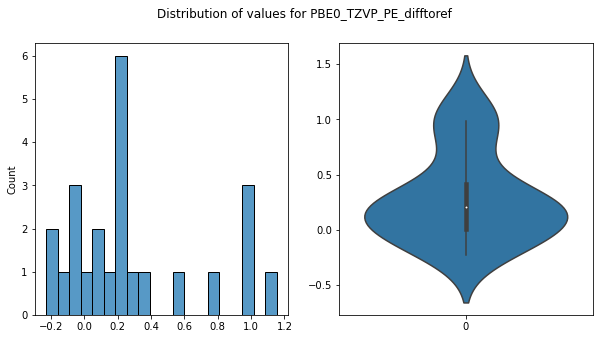

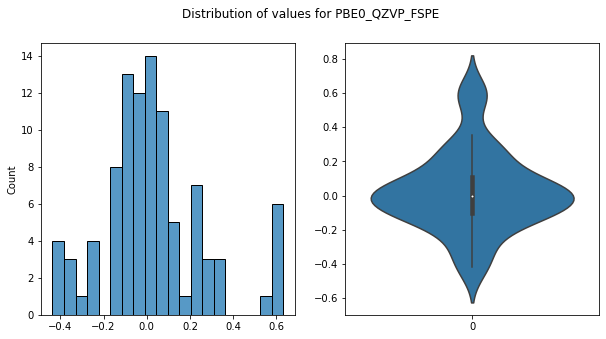

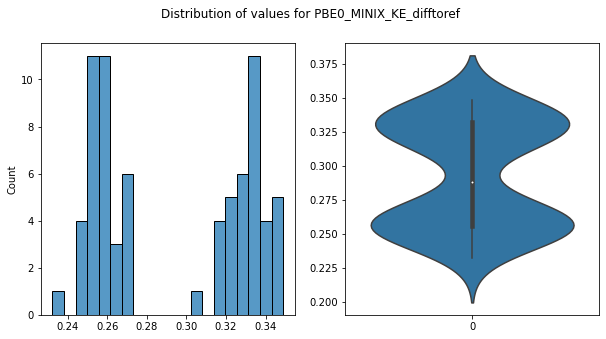

In [6]:
for fn in featnames:
    allval = plot_featurename_distribution(fn)
